# Helmholtz problem

This example notebook shows how to setup and solve the time-harmonic acoustic propagation problem, which is governed by the Helmholtz equation.

The Helmholtz equation is given by Fourier transforming the wave equation in the temporal domain, which gives

$$
    \left(\nabla +\frac{\omega^2}{c^2}\right)\phi = i \omega S_M,
$$

with $P, S_M \in C^{2}(\mathbb{C})$. 

In `jwave`, the Helmholtz equation solved also takes into account heterogeneous absorption and density, and it is given as
$$
\left(\frac{\omega^2}{c_0^2} + \nabla^2  - \frac{1}{\rho_0} \nabla \rho_0 \cdot \nabla  + \frac{2i\omega^3\alpha_0}{c_0} \right)P = i \omega S_M
$$
where:
- $\omega =2\pi f_0$ is the angular frequency, and $f_0$ is the frequency of the wave
- $\rho_0$ is the material density
- $\alpha_0$ is the attenuation coefficient
- $S_M$ is the mass source term

Before running the simulation, we'll import the necessary modules and utility functions

In [1]:
from functools import partial

import numpy as np
from jax import jit
from jax import numpy as jnp
from jax import random
from matplotlib import pyplot as plt

from jwave import FiniteDifferences, FourierSeries
from jwave.geometry import Domain, Medium, _circ_mask
from jwave.utils import plot_complex_field, show_positive_field

key = random.PRNGKey(42)  # Random seed

In [2]:
# Defining geometry
N = (128, 256)  # Grid size
dx = (0.001, 0.001)  # Spatial resolution
omega = 1.5e6  # Wavefield omega = 2*pi*f
target = [160, 360]  # Target location

# Defining the domain
domain = Domain(N, dx)

Performing time-harmonic simulations is very similar to standard wave propagation, with the difference that the source field is a static complex field.

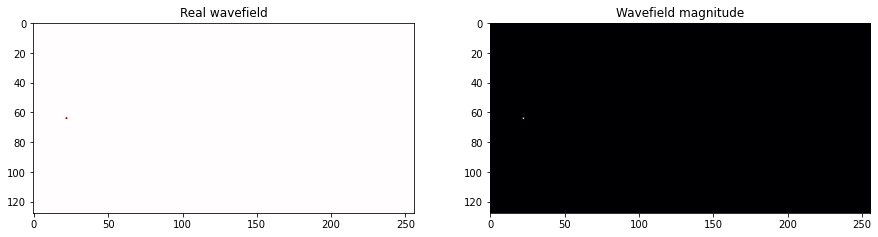

In [3]:
# Build the vector that holds the parameters of the apodization an the
# functions required to transform it into a source wavefield
src_field = jnp.zeros(N).astype(jnp.complex64)
src_field = src_field.at[64, 22].set(1.0)
src = FourierSeries(jnp.expand_dims(src_field, -1), domain) * omega

# Plotting
_ = plot_complex_field(src)

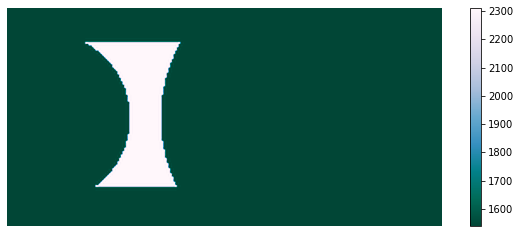

In [4]:
# Constructing medium physical properties
sound_speed = jnp.zeros(N)
sound_speed = sound_speed.at[20:105, 20:200].set(1.0)
sound_speed = (
    sound_speed
    * (1 - _circ_mask(N, 90, [64, 180]))
    * (1 - _circ_mask(N, 50, [64, 22]))
    * 0.5
    + 1
)
sound_speed = FourierSeries(jnp.expand_dims(sound_speed, -1), domain) * 1540
density = 1  # sound_speed*0 + 1.
attenuation = 0.0  # density*0

medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=15)

# Show sound speed
_ = show_positive_field(sound_speed, aspect="equal", figsize=(10, 4))

In [5]:
from jwave.acoustics.time_harmonic import helmholtz, helmholtz_solver

params = helmholtz(src, medium, omega)._op_params


@jit
def solve_helmholtz(medium):
    return helmholtz_solver(medium, omega, src, params=params)


field = solve_helmholtz(medium)

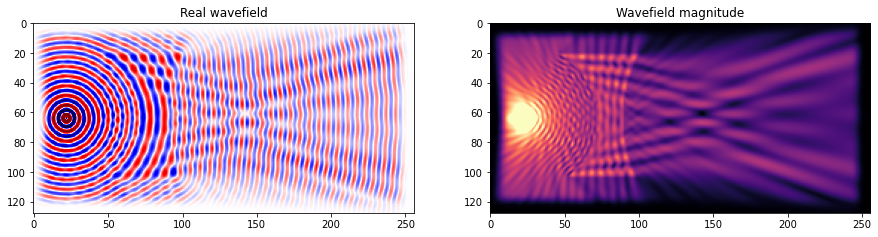

In [6]:
_ = plot_complex_field(field, max_intensity=0.1)

In [7]:
print("Runtime with GMRES")
%timeit solve_helmholtz(medium).params.block_until_ready()

Runtime with GMRES
296 ms ± 517 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Heterogeneous density

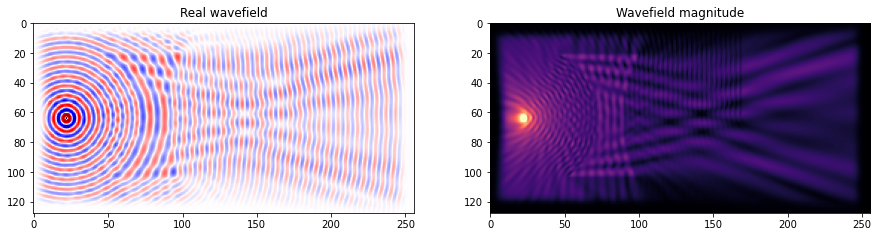

In [10]:
density = jnp.ones(N)
density = jnp.expand_dims(density.at[:64, 170:].set(1.5), -1)
density = FourierSeries(density, domain)

medium = Medium(domain=domain, sound_speed=sound_speed, density=density, pml_size=15)

# Solve new problem
field = solve_helmholtz(medium)
_ = plot_complex_field(field, max_intensity=0.2)

### Heterogeneous attenuation

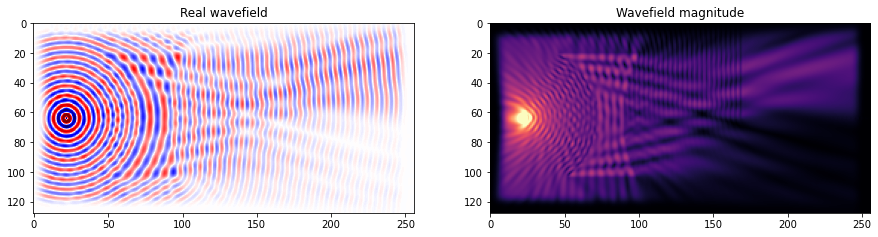

In [13]:
attenuation = jnp.zeros(N)
attenuation = jnp.expand_dims(attenuation.at[64:110, 125:220].set(32), -1)

medium = Medium(
    domain=domain,
    sound_speed=sound_speed,
    density=density,
    attenuation=attenuation,
    pml_size=15,
)

# Solve new problem
field = solve_helmholtz(medium)
_ = plot_complex_field(field, max_intensity=0.15)

In [14]:
print("Runtime with GMRES (heterog. density and attenuation)")
%timeit solve_helmholtz(medium).params.block_until_ready()

Runtime with GMRES (heterog. density and attenuation)
448 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
